# Data fetching

In [244]:
from io import StringIO
import re
import requests

import jax.numpy as np
from jax.random import PRNGKey

import numpy as onp
import pandas as pd

import numpyro
from numpyro.diagnostics import hpdi
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [1]:
# country codes
isocodes = pd.read_csv('../input/countries-iso-codes/wikipedia-iso-country-codes.csv')
isocodes.columns = isocodes.columns.str.replace(' ', '_').str.lower()
isocodes = isocodes.rename({"english_short_name_lower_case": 'country_name'}, axis=1)

# url = 'https://data.humdata.org/dataset/e1a91ae0-292d-4434-bc75-bf863d4608ba/resource/a636aad6-f40a-4a2c-ab83-7625d7b9d64d/download/acaps_covid19_goverment_measures_dataset.xlsx'
# measures = pd.read_excel(url, sheet_name='Database')
# measures.to_csv('acaps.csv', index=False)

# ACAPS
measures = pd.read_csv('acaps.csv')
measures.columns = measures.columns.str.lower()
measures['date_implemented'] = pd.to_datetime(measures['date_implemented'])

measures = measures.merge(isocodes, left_on='iso', right_on='alpha-3_code')
measures

In [2]:
# ECDC for names of lactions
ecdc = (pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
        .assign(date=lambda f: f['date'].pipe(pd.to_datetime))
       )

In [250]:
# Apple mobility
# url = 'https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev47/v2/en-us/applemobilitytrends-2020-05-03.csv'
# response = requests.get(url)

# apple_mobility = (pd.read_csv(StringIO(response.content.decode())))
# apple_mobility.to_csv('apple.csv', index=False)

apple_mobility = (pd.read_csv('apple.csv')
                  .drop('alternative_name', axis=1)
                  .set_index(['geo_type', 'region', 'transportation_type'])
                  .rename_axis("date", axis=1)
                  .stack()
                  .rename('change')
                  .reset_index('date')
                  .assign(date=lambda f: pd.to_datetime(f['date']))
                  .set_index('date', append=True)
                  )

location_code = ecdc.groupby(['location', 'iso_code']).first().iloc[:, 0].reset_index().iloc[:,:2]

apple_mobility = (apple_mobility
                  .reset_index()
                  .replace({'UK': 'United Kingdom', 'Republic of Korea': 'South Korea', 'Macao': 'Macau'})  # Only missing is Macao
                  .merge(location_code, left_on='region', right_on='location', how='left')
                 .assign(change=lambda f: f['change'].div(100).sub(1)))

apple_mobility = apple_mobility.query('iso_code.notna()').set_index(['iso_code', 'date', 'transportation_type'])['change'].unstack()
apple_mobility

transportation_type  driving  transit  walking
iso_code date                                 
ALB      2020-01-13   0.0000      NaN   0.0000
         2020-01-14  -0.0470      NaN   0.0068
         2020-01-15   0.0143      NaN  -0.0107
         2020-01-16  -0.0280      NaN  -0.0154
         2020-01-17   0.0355      NaN   0.0085
...                      ...      ...      ...
ZAF      2020-04-29  -0.7225      NaN  -0.6568
         2020-04-30  -0.6819      NaN  -0.6099
         2020-05-01  -0.6205      NaN  -0.5629
         2020-05-02  -0.6415      NaN  -0.5994
         2020-05-03  -0.6592      NaN  -0.6394

[7280 rows x 3 columns]

In [270]:
google_mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', parse_dates=['date'])

def safe_match(pat, text):
    match = re.match(pat, text)
    return match.groups()[0] if match else text

google_mobility.columns = google_mobility.columns.map(lambda col: safe_match("(.*)_percent", col))
google_mobility = (google_mobility
            .merge(isocodes, left_on='country_region_code', right_on='alpha-2_code', how='left')
            .merge(location_code, left_on='alpha-3_code', right_on='iso_code', how='left'))

google_mobility = google_mobility.query('sub_region_1.isna()').set_index(['iso_code', 'date']).select_dtypes(float).div(100)
google_mobility

/home/horace/miniconda3/envs/uncoverun/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


retail_and_recreation  grocery_and_pharmacy  parks  \
iso_code date                                                             
ARE      2020-02-15                   0.00                  0.04   0.05   
         2020-02-16                   0.01                  0.04   0.04   
         2020-02-17                  -0.01                  0.01   0.05   
         2020-02-18                  -0.02                  0.01   0.05   
         2020-02-19                  -0.02                  0.00   0.04   
...                                    ...                   ...    ...   
ZWE      2020-04-22                  -0.57                 -0.43  -0.42   
         2020-04-23                  -0.56                 -0.44  -0.42   
         2020-04-24                  -0.57                 -0.43  -0.46   
         2020-04-25                  -0.58                 -0.42  -0.41   
         2020-04-26                  -0.53                 -0.42  -0.35   

                     transit_stations  workplaces  residential  
iso_code date                                                   
ARE      2020-02-15              0.00        0.02         0.01  
         2020-02-16              0.01        0.02         0.01  
         2020-02-17              0.01        0.02         0.01  
         2020-02-18              0.00        0.02         0.01  
         2020-02-19             -0.01        0.02         0.01  
...                               ...         ...          ...  
ZWE      2020-04-22             -0.71       -0.58         0.37  
         2020-04-23             -0.73       -0.58         0.38  
         2020-04-24             -0.74       -0.56         0.39  
         2020-04-25             -0.73       -0.43         0.30  
         2020-04-26             -0.70       -0.23         0.28  

[9504 rows x 6 columns]

In [292]:
mobility = google_mobility.join(apple_mobility, how='outer')
mobility

retail_and_recreation  grocery_and_pharmacy  parks  \
iso_code date                                                             
ABW      2020-02-15                   0.02                  0.03   0.12   
         2020-02-16                  -0.01                 -0.09   0.04   
         2020-02-17                  -0.01                 -0.01   0.16   
         2020-02-18                  -0.02                 -0.05   0.08   
         2020-02-19                   0.01                 -0.08   0.03   
...                                    ...                   ...    ...   
ZAF      2020-04-29                    NaN                   NaN    NaN   
         2020-04-30                    NaN                   NaN    NaN   
         2020-05-01                    NaN                   NaN    NaN   
         2020-05-02                    NaN                   NaN    NaN   
         2020-05-03                    NaN                   NaN    NaN   

                     transit_stations  workplaces  residential  driving  \
iso_code date                                                             
ABW      2020-02-15              0.26       -0.02        -0.02      NaN   
         2020-02-16              0.01       -0.01         0.00      NaN   
         2020-02-17             -0.04       -0.20         0.06      NaN   
         2020-02-18              0.02       -0.13         0.04      NaN   
         2020-02-19              0.04       -0.14         0.04      NaN   
...                               ...         ...          ...      ...   
ZAF      2020-04-29               NaN         NaN          NaN  -0.7225   
         2020-04-30               NaN         NaN          NaN  -0.6819   
         2020-05-01               NaN         NaN          NaN  -0.6205   
         2020-05-02               NaN         NaN          NaN  -0.6415   
         2020-05-03               NaN         NaN          NaN  -0.6592   

                     transit  walking  
iso_code date                          
ABW      2020-02-15      NaN      NaN  
         2020-02-16      NaN      NaN  
         2020-02-17      NaN      NaN  
         2020-02-18      NaN      NaN  
         2020-02-19      NaN      NaN  
...                      ...      ...  
ZAF      2020-04-29      NaN  -0.6568  
         2020-04-30      NaN  -0.6099  
         2020-05-01      NaN  -0.5629  
         2020-05-02      NaN  -0.5994  
         2020-05-03      NaN  -0.6394  

[12536 rows x 9 columns]

In [272]:
# oxford.columns[mask].str.extract(r'(..)_.*', expand=False)

oxford = pd.read_csv('https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/OxCGRT_latest.csv')
oxford.columns = oxford.columns.map(str.lower).str.replace(' ', '_')
oxford['date'] = pd.to_datetime(oxford['date'], format='%Y%m%d')

oxford

,countryname,countrycode,date,c1_school_closing,c1_flag,c2_workplace_closing,c2_flag,c3_cancel_public_events,c3_flag,c4_restrictions_on_gatherings,...,h3_contact_tracing,h4_emergency_investment_in_healthcare,h5_investment_in_vaccines,m1_wildcard,confirmedcases,confirmeddeaths,stringencyindex,stringencyindexfordisplay,legacystringencyindex,legacystringencyindexfordisplay
0,Aruba,ABW,2020-01-01,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
1,Aruba,ABW,2020-01-02,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
2,Aruba,ABW,2020-01-03,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
3,Aruba,ABW,2020-01-04,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
4,Aruba,ABW,2020-01-05,0.0,NaN,0.0,NaN,0.0,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19017,Kosovo,RKS,2020-04-30,3.0,1.0,2.0,1.0,2.0,1.0,4.0,...,NaN,NaN,NaN,NaN,806.0,22.0,83.6,83.6,82.14,82.14
19018,Kosovo,RKS,2020-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,806.0,22.0,NaN,83.6,NaN,82.14
19019,Kosovo,RKS,2020-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,823.0,22.0,NaN,83.6,NaN,82.14
19020,Kosovo,RKS,2020-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,851.0,22.0,NaN,83.6,NaN,82.14


In [273]:
ordinal_columns = oxford.columns[oxford.columns.str.contains("^c._.*_.*")]
geographic_columns = oxford.columns[oxford.columns.str.contains('^c._flag')]
strip_measure_name = lambda name: name.split('_')[0]
measures_ix = dict(zip(ordinal_columns.map(strip_measure_name), ordinal_columns.map(lambda s: '_'.join(s.split('_')[1:]))))

oxford_long = (oxford
               .set_index(['countrycode', 'date'])
               [geographic_columns]
               .rename(columns=strip_measure_name)
               .rename_axis('category', axis=1)
               .stack()
               .to_frame('flag')
               .join(oxford.set_index(['countrycode', 'date'])
                     [ordinal_columns]
                     .rename(columns=strip_measure_name)
                     .replace(0, np.nan)
                     .rename_axis('category', axis=1)
                     .stack()
                     .rename('measure'),
                     how='outer'
                    )
              )

oxford_long = (oxford_long
               .rename_axis('variable', axis=1)
               .stack()
               .rename('value'))

print(oxford_long.shape)
print(measures_ix)
oxford_long.loc['FRA']

(97378,)
{'c1': 'school_closing', 'c2': 'workplace_closing', 'c3': 'cancel_public_events', 'c4': 'restrictions_on_gatherings', 'c5': 'close_public_transport', 'c6': 'stay_at_home_requirements', 'c7': 'restrictions_on_internal_movement', 'c8': 'international_travel_controls'}


date        category  variable
2020-01-23  c8        measure     1.0
2020-01-24  c8        measure     1.0
2020-01-25  c8        measure     1.0
2020-01-26  c8        measure     1.0
2020-01-27  c8        measure     1.0
                                 ... 
2020-05-01  c6        flag        1.0
                      measure     2.0
            c7        flag        1.0
                      measure     2.0
            c8        measure     4.0
Name: value, Length: 816, dtype: float64

In [274]:
oxford_long.loc['FRA'].unstack(-2)

category              c1   c2   c3   c4   c5   c6   c7   c8
date       variable                                        
2020-01-23 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-24 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-25 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-26 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
2020-01-27 measure   NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0
...                  ...  ...  ...  ...  ...  ...  ...  ...
2020-04-29 measure   3.0  3.0  2.0  4.0  1.0  2.0  2.0  4.0
2020-04-30 flag      1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN
           measure   3.0  3.0  2.0  4.0  1.0  2.0  2.0  4.0
2020-05-01 flag      1.0  1.0  1.0  1.0  1.0  1.0  1.0  NaN
           measure   3.0  3.0  2.0  4.0  1.0  2.0  2.0  4.0

[163 rows x 8 columns]

# Inference

In [275]:
oxford_long

countrycode  date        category  variable
ABW          2020-03-15  c8        measure     3.0
             2020-03-16  c1        flag        1.0
                                   measure     3.0
                         c8        measure     3.0
             2020-03-17  c1        flag        1.0
                                              ... 
ZWE          2020-05-04  c6        flag        1.0
                                   measure     2.0
                         c7        flag        1.0
                                   measure     2.0
                         c8        measure     4.0
Name: value, Length: 97378, dtype: float64

In [332]:
first_notna[0]

Timestamp('2020-02-15 00:00:00')

In [347]:
subset_mobility = mobility.loc[country]
for col in subset_mobility.columns:
    first_notna = subset_mobility[col].notna().cumsum().loc[lambda x: x == 1].index[0]
    subset_mobility.loc[:first_notna, col] = 0.

subset_mobility.fillna(method='ffill', limit=50)

<ipython-input-347-e4d5ac3e30d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_mobility.loc[:first_notna, col] = 0.


,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,transit,walking
date,,,,,,,,,
2020-02-15,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000
2020-02-16,0.06,0.02,0.09,0.07,-0.01,-0.01,-0.0329,0.0179,-0.2556
2020-02-17,0.01,0.02,0.16,-0.06,-0.15,0.04,0.0032,0.1854,-0.1310
2020-02-18,0.05,0.02,0.36,-0.04,-0.14,0.03,0.0083,0.1854,-0.0409
2020-02-19,-0.04,-0.03,0.18,-0.06,-0.12,0.02,0.0203,0.1632,-0.0597
...,...,...,...,...,...,...,...,...,...
2020-04-29,-0.83,-0.58,-0.68,-0.77,-0.43,0.16,-0.5768,-0.8190,-0.8104
2020-04-30,-0.83,-0.58,-0.68,-0.77,-0.43,0.16,-0.6053,-0.8264,-0.8112
2020-05-01,-0.83,-0.58,-0.68,-0.77,-0.43,0.16,-0.6935,-0.8401,-0.8433


In [366]:
ix = pd.IndexSlice

def build_dataset(country, mobility, oxford_long):
    subset_mobility = mobility.loc[country].copy().sort_index()
    for col in subset_mobility.columns:
        first_notna = subset_mobility[col].notna().cumsum().loc[lambda x: x == 1].index[0]
        subset_mobility.loc[:first_notna, col] = 0.

    subset_mobility = subset_mobility.fillna(method='ffill', limit=50)

    subset_measures = (oxford_long
                       .unstack(-1)
                       .loc[country]
                       .query('flag != flag or flag == 1.')
                       ['measure']
                       .unstack()
                       .reindex(['c' + str(i) for i in range(1, 9)], axis=1))

    common_ix = subset_measures.index.union(subset_mobility.index)
    subset_measures = subset_measures.reindex(common_ix).fillna(method='ffill').fillna(0)
    subset_mobility = subset_mobility.reindex(common_ix)
    return subset_measures, subset_mobility

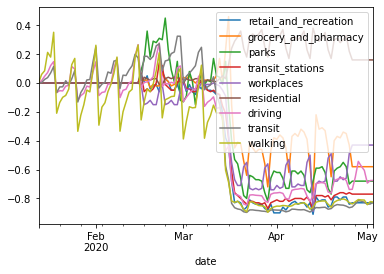

In [367]:
meas, mob = build_dataset('FRA', mobility, oxford_long)
mob.plot()

In [368]:
def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

def model(nb_measures, nb_mobilities, nb_countries=1, measures=None, mobility=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    alpha = numpyro.sample('alpha', 
                           dist.Gamma(*reparametrize_gamma(1. / nb_measures, 1.)), 
                           sample_shape=(nb_measures, nb_mobilities))
    alpha -= np.log(1.05) / nb_measures
    mu = np.exp(- np.dot(measures, alpha)) + a
    sigma = numpyro.sample('sigma', dist.Exponential(1.), sample_shape=(nb_mobilities,))
    numpyro.sample('y', dist.Normal(mu, sigma), obs=mobility)

In [369]:
oxford_long.reset_index()['countrycode'].unique()

array(['ABW', 'AFG', 'AGO', 'ALB', 'AND', 'ARE', 'ARG', 'AUS', 'AUT',
       'AZE', 'BDI', 'BEL', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLZ',
       'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BWA', 'CAN', 'CHE', 'CHL',
       'CHN', 'CMR', 'COD', 'COL', 'CPV', 'CRI', 'CUB', 'CYP', 'CZE',
       'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ESP',
       'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GHA', 'GMB', 'GRC',
       'GRL', 'GTM', 'GUM', 'GUY', 'HKG', 'HND', 'HRV', 'HUN', 'IDN',
       'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR',
       'JPN', 'KAZ', 'KEN', 'KGZ', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY',
       'LKA', 'LSO', 'LUX', 'MAC', 'MAR', 'MDA', 'MDG', 'MEX', 'MLI',
       'MMR', 'MNG', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYS', 'NAM', 'NER',
       'NGA', 'NIC', 'NLD', 'NOR', 'NZL', 'OMN', 'PAK', 'PAN', 'PER',
       'PHL', 'PNG', 'POL', 'PRI', 'PRT', 'PRY', 'PSE', 'QAT', 'RKS',
       'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SGP', 'SLE', 'SLV', 'SMR',
       'SRB', 'SSD',

In [370]:
def plot_mobility_results(mu, pi, y_true, times):
    plt.plot(times, y_true + 1, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

In [371]:
def run_mcmc(country, subset_measures, subset_mobility, mcmc=None, model=model):
    NB_MEASURES = subset_measures.shape[1]
    NB_MOBILITIES = subset_mobility.shape[1]
    
    mcmc = mcmc or MCMC(NUTS(model, dense_mass=True), 2000, 2000, num_chains=1, progress_bar=True)
    mcmc.run(PRNGKey(0), 
             NB_MEASURES, NB_MOBILITIES, 
             measures=subset_measures.to_numpy(), 
             mobility=subset_mobility.to_numpy() + 1.)
    mcmc.print_summary()
    return mcmc

sample: 100%|██████████| 4000/4000 [01:31<00:00, 43.89it/s, 1023 steps of size 7.42e-05. acc. prob=0.88]
/home/horace/miniconda3/envs/uncoverun/lib/python3.8/site-packages/numpyro/diagnostics.py:172: RuntimeWarning: invalid value encountered in true_divide
  rho_k = 1. - (var_within - gamma_k_c.mean(axis=0)) / var_estimator



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.03      0.00      0.03      0.02      0.03      2.85      1.98
alpha[0,0]      0.00      0.00      0.00      0.00      0.00     42.57      1.03
alpha[0,1]      0.00      0.00      0.00      0.00      0.00     32.62      1.19
alpha[0,2]      0.02      0.04      0.00      0.00      0.08      6.11      1.26
alpha[0,3]      0.11      0.02      0.11      0.08      0.14     16.54      1.02
alpha[0,4]      0.31      0.02      0.32      0.28      0.35      6.60      1.37
alpha[0,5]      0.00      0.00      0.00      0.00      0.00     22.81      1.05
alpha[0,6]      0.12      0.07      0.14      0.00      0.21      7.26      1.00
alpha[0,7]      0.00      0.00      0.00      0.00      0.00      4.74      1.36
alpha[0,8]      0.49      0.06      0.49      0.40      0.60     18.51      1.02
alpha[1,0]      0.05      0.06      0.00      0.00      0.13      2.98      2.18
alpha[1,1]      0.00      0

sample: 100%|██████████| 4000/4000 [01:11<00:00, 55.77it/s, 1023 steps of size 5.00e-01. acc. prob=0.80] 
/home/horace/miniconda3/envs/uncoverun/lib/python3.8/site-packages/numpyro/diagnostics.py:172: RuntimeWarning: invalid value encountered in true_divide
  rho_k = 1. - (var_within - gamma_k_c.mean(axis=0)) / var_estimator



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.02      0.00      0.02      0.02      0.02   1683.76      1.00
alpha[0,0]      0.11      0.05      0.12      0.04      0.19     36.25      1.06
alpha[0,1]      0.12      0.01      0.12      0.11      0.13    402.47      1.01
alpha[0,2]      0.00      0.00      0.00      0.00      0.00     37.02      1.05
alpha[0,3]      0.25      0.06      0.26      0.19      0.34     30.71      1.02
alpha[0,4]      0.35      0.05      0.36      0.29      0.41     34.08      1.04
alpha[0,5]      0.00      0.00      0.00      0.00      0.00     84.68      1.01
alpha[0,6]      0.08      0.05      0.10      0.00      0.15     11.90      1.08
alpha[0,7]      0.22      0.10      0.25      0.00      0.32     16.02      1.10
alpha[0,8]      0.02      0.05      0.00      0.00      0.09     10.96      1.24
alpha[1,0]      0.00      0.00      0.00      0.00      0.01     28.47      1.01
alpha[1,1]      0.00      0

sample: 100%|██████████| 4000/4000 [01:09<00:00, 57.29it/s, 1023 steps of size 6.77e-01. acc. prob=0.73] 
/home/horace/miniconda3/envs/uncoverun/lib/python3.8/site-packages/numpyro/diagnostics.py:172: RuntimeWarning: invalid value encountered in true_divide
  rho_k = 1. - (var_within - gamma_k_c.mean(axis=0)) / var_estimator



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.05      0.01      0.05      0.04      0.06    496.66      1.02
alpha[0,0]      0.07      0.02      0.07      0.05      0.10     28.65      1.04
alpha[0,1]      0.00      0.00      0.00      0.00      0.00    116.03      1.01
alpha[0,2]      0.05      0.02      0.05      0.02      0.08    251.97      1.01
alpha[0,3]      0.07      0.05      0.10      0.00      0.13      3.31      1.78
alpha[0,4]      0.02      0.02      0.00      0.00      0.06      8.90      1.33
alpha[0,5]      0.00      0.00      0.00      0.00      0.00    181.77      1.01
alpha[0,6]      0.11      0.05      0.12      0.00      0.15      7.69      1.16
alpha[0,7]      0.23      0.09      0.26      0.00      0.31      7.43      1.17
alpha[0,8]      0.00      0.00      0.00      0.00      0.00       nan       nan
alpha[1,0]      0.45      0.04      0.45      0.39      0.52    403.12      1.00
alpha[1,1]      0.00      0

sample: 100%|██████████| 4000/4000 [01:26<00:00, 46.21it/s, 1023 steps of size 1.04e-04. acc. prob=0.89]
/home/horace/miniconda3/envs/uncoverun/lib/python3.8/site-packages/numpyro/diagnostics.py:172: RuntimeWarning: invalid value encountered in true_divide
  rho_k = 1. - (var_within - gamma_k_c.mean(axis=0)) / var_estimator



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.02      0.00      0.02      0.01      0.03      3.57      1.75
alpha[0,0]      0.00      0.00      0.00      0.00      0.00      9.38      1.15
alpha[0,1]      0.10      0.01      0.10      0.08      0.12      9.00      1.03
alpha[0,2]      0.00      0.00      0.00      0.00      0.00     52.40      1.01
alpha[0,3]      0.05      0.05      0.00      0.00      0.13      2.76      2.63
alpha[0,4]      0.11      0.02      0.11      0.08      0.15     10.08      1.01
alpha[0,5]      0.00      0.00      0.00      0.00      0.00       nan       nan
alpha[0,6]      0.00      0.00      0.00      0.00      0.00     17.20      1.06
alpha[0,7]      0.00      0.00      0.00      0.00      0.00     63.59      1.03
alpha[0,8]      0.00      0.00      0.00      0.00      0.00     10.74      1.12
alpha[1,0]      0.15      0.04      0.15      0.09      0.23      3.47      1.67
alpha[1,1]      0.00      0

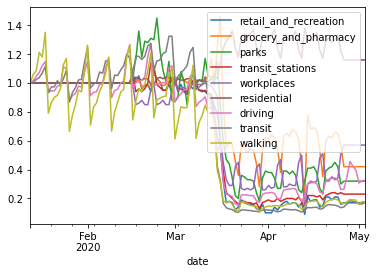

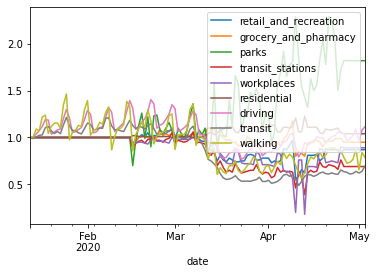

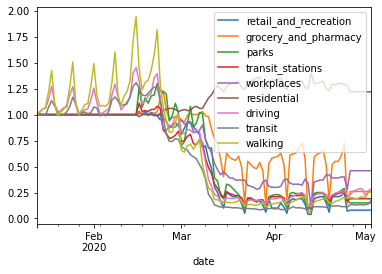

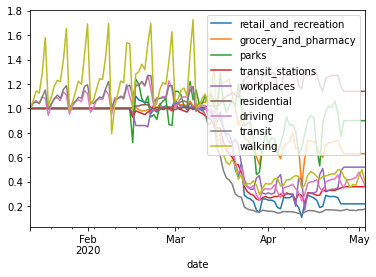

In [375]:
country_codes = ['FRA', 'SWE', 'ITA', 'GBR']

mcmc = None
for country in country_codes:
    subset_measures, subset_mobility = build_dataset(country, mobility, oxford_long)
    mcmc = run_mcmc(country, subset_measures, subset_mobility, mcmc=mcmc)

In [376]:
def plot_y_pred(y_pred, data, times, country):
    mu = np.mean(y_pred, 0)
    pi = np.percentile(y_pred, (10., 90.), 0)
    for i in range(data.shape[1]):
        fig, ax = plt.subplots(figsize=(8, 5))
        plot_mobility_results(mu[:, i], pi[:, :, i], data[:, i], times)
        plt.title(subset_mobility.columns[i] + ' ' + country)

FRA
SWE
ITA


<ipython-input-376-958c3c8219bf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 5))
<ipython-input-376-958c3c8219bf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 5))
<ipython-input-376-958c3c8219bf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f

GBR


<ipython-input-376-958c3c8219bf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 5))
<ipython-input-376-958c3c8219bf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 5))
<ipython-input-376-958c3c8219bf>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f

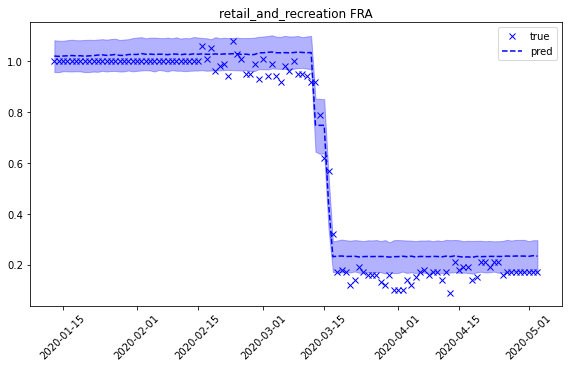

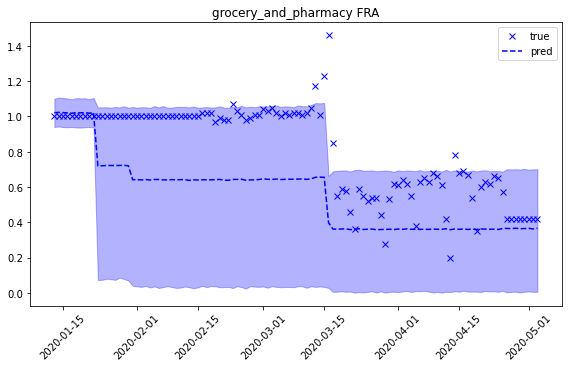

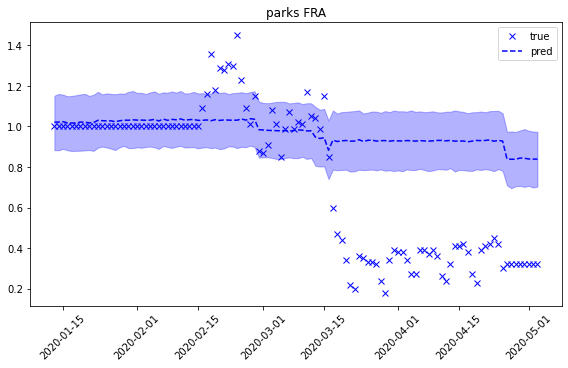

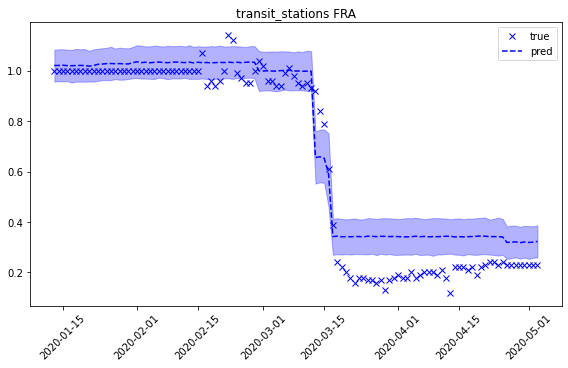

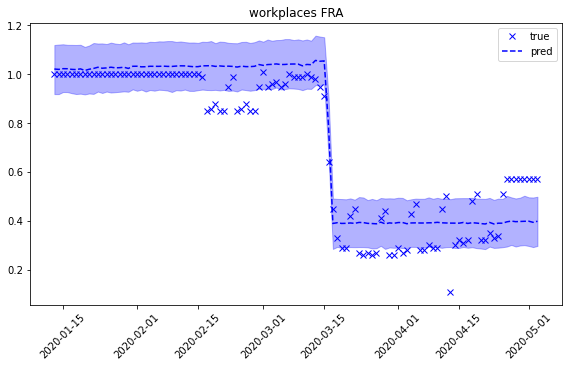

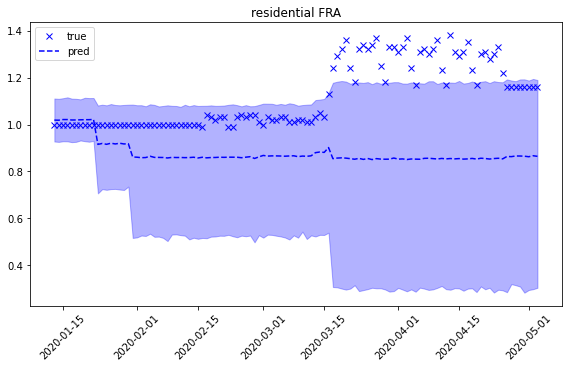

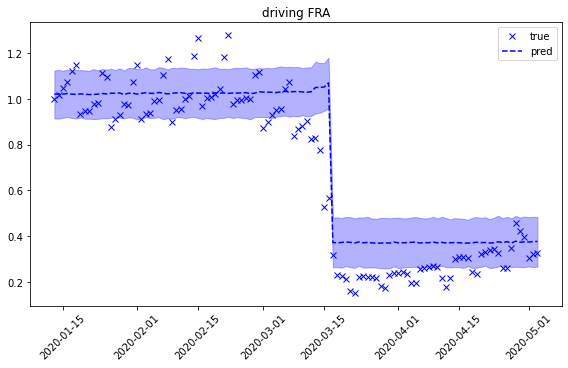

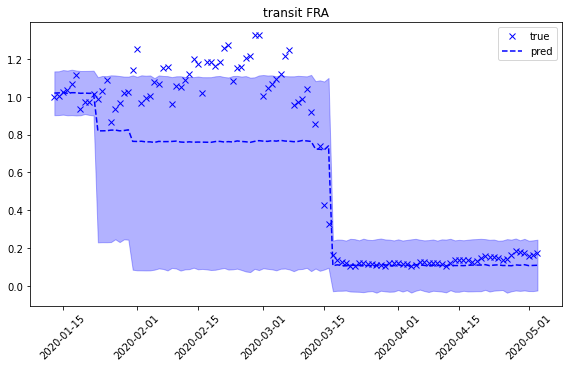

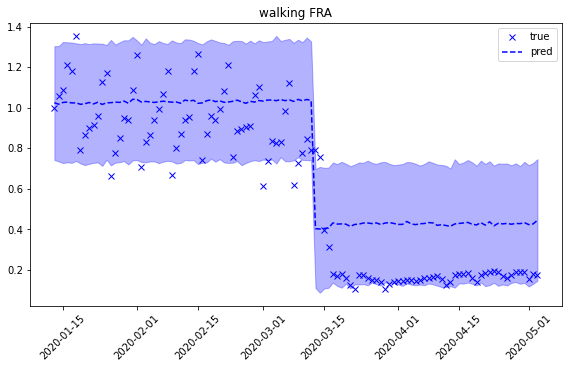

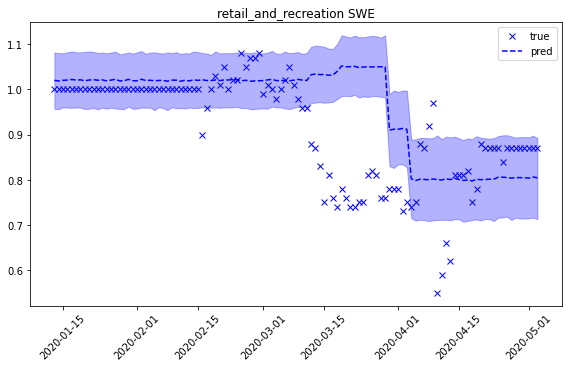

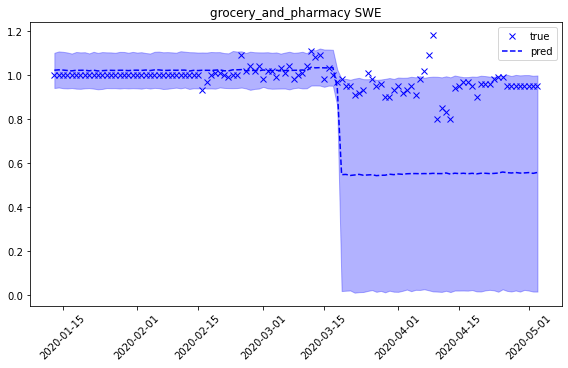

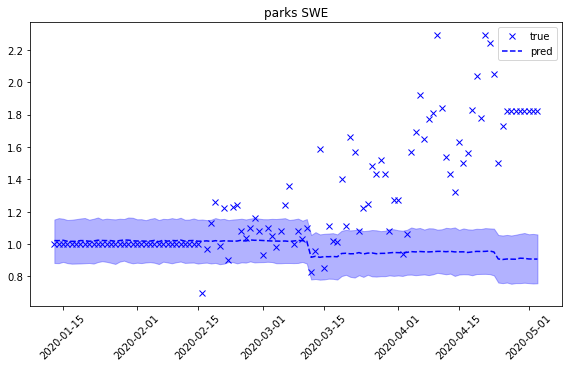

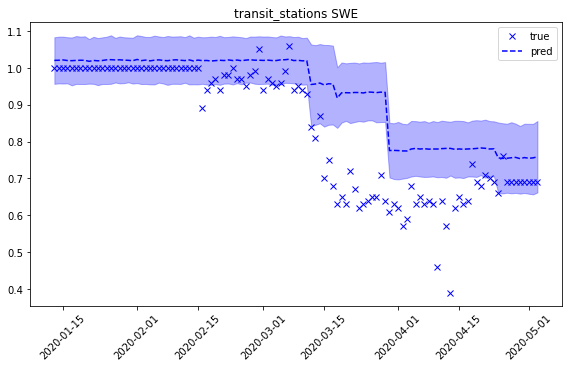

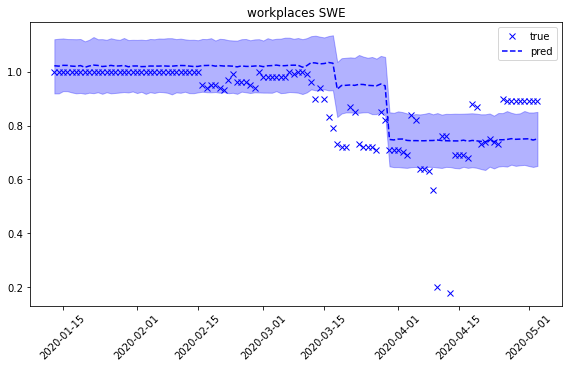

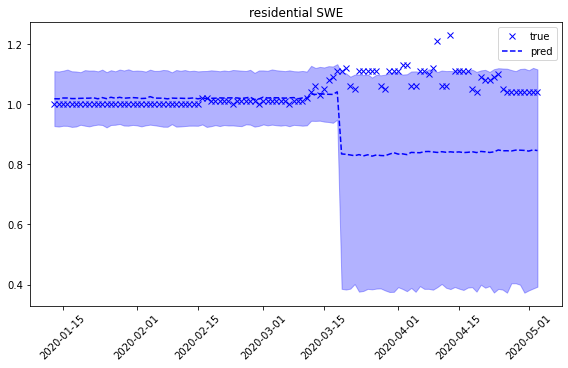

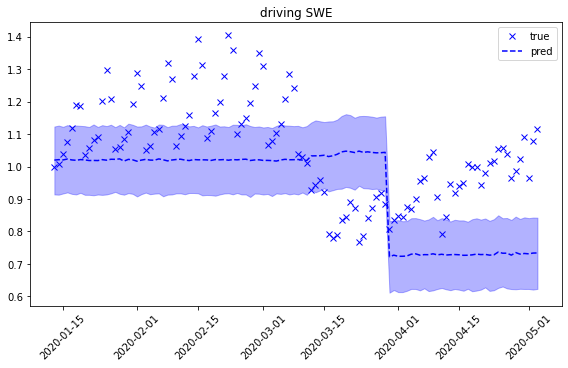

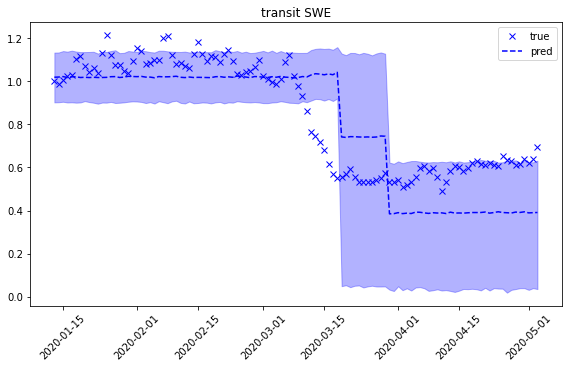

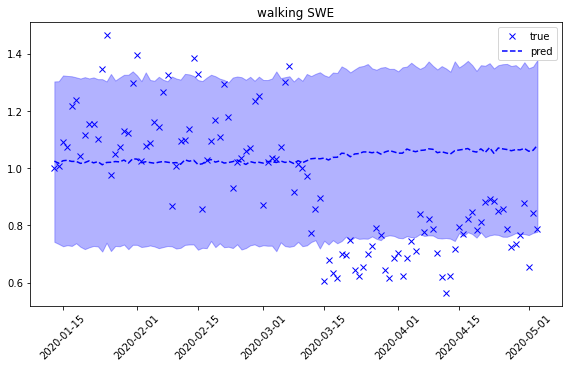

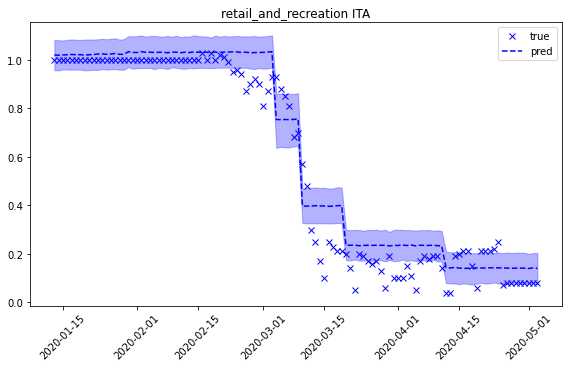

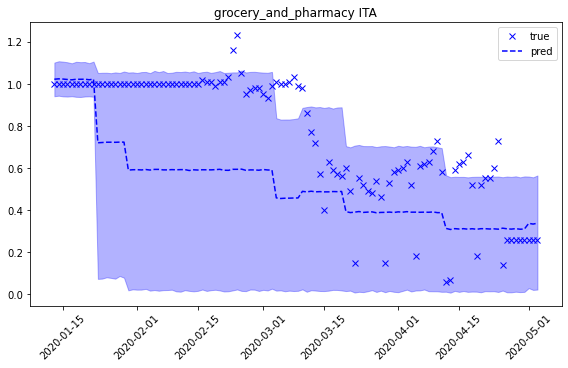

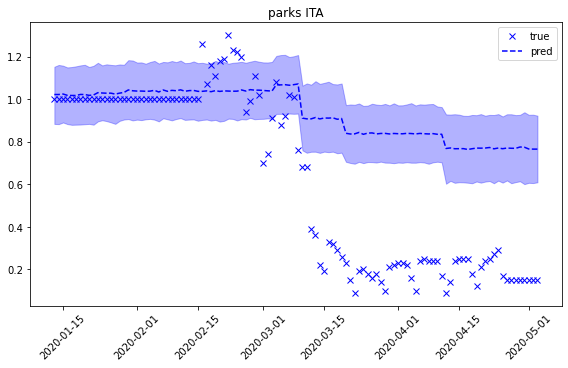

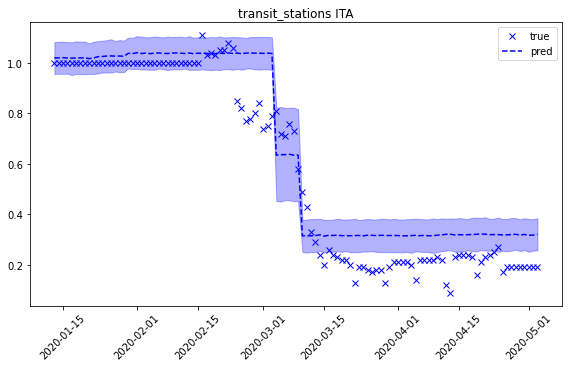

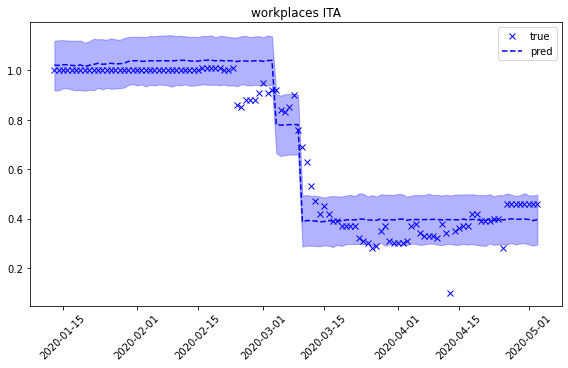

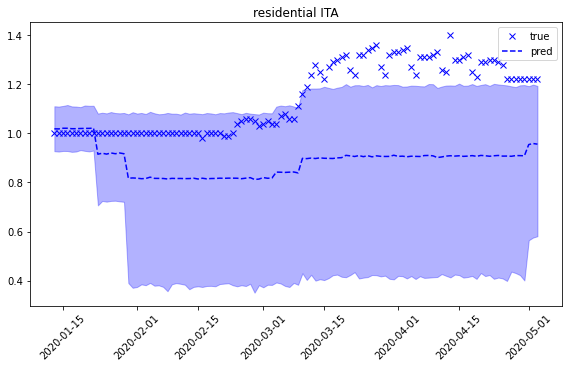

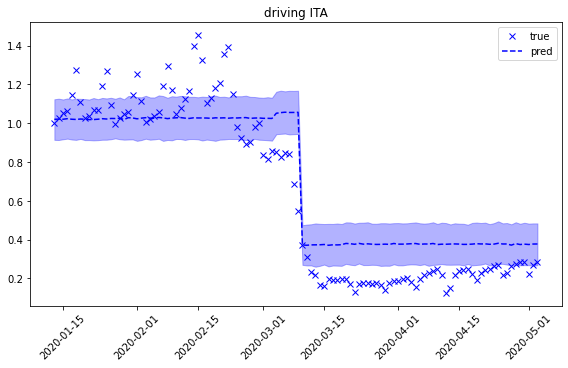

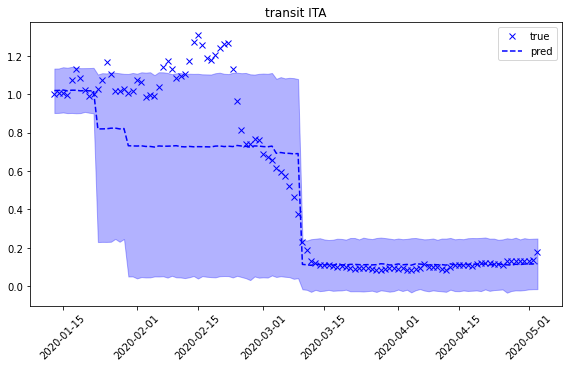

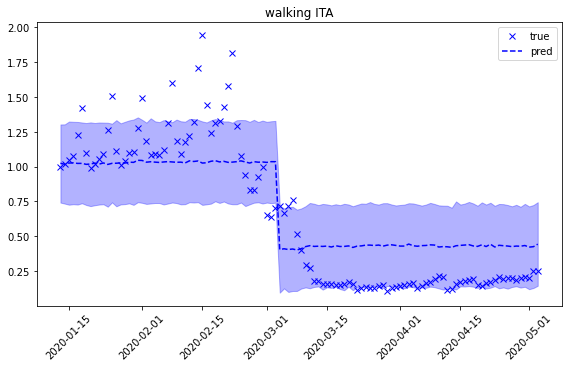

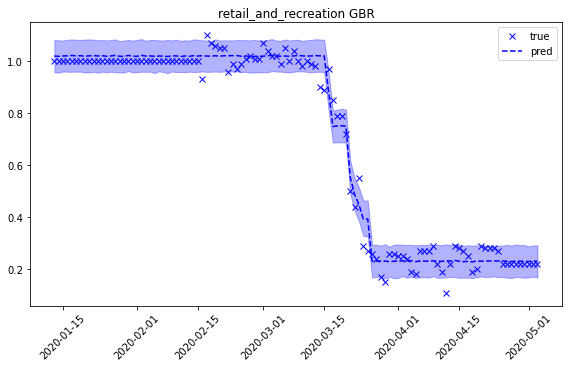

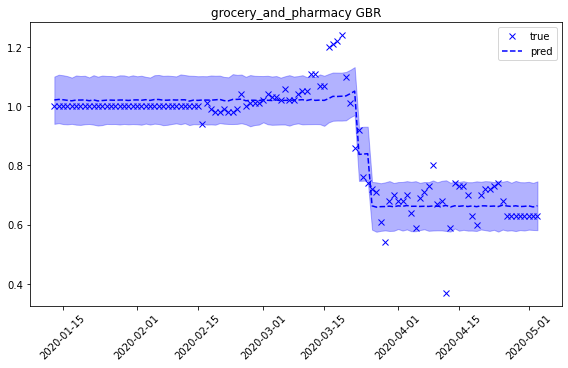

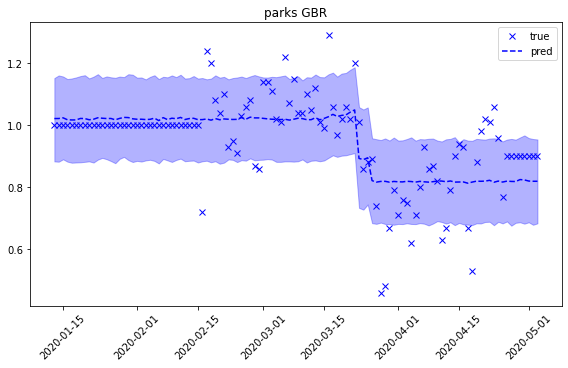

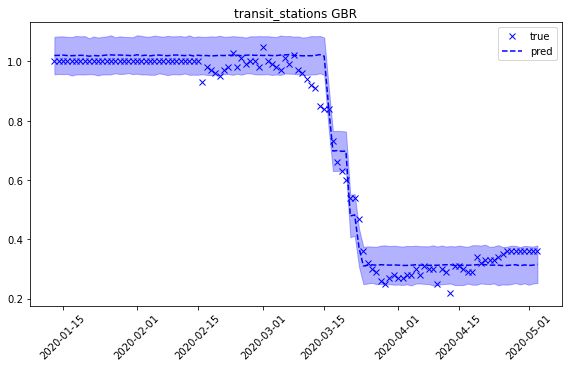

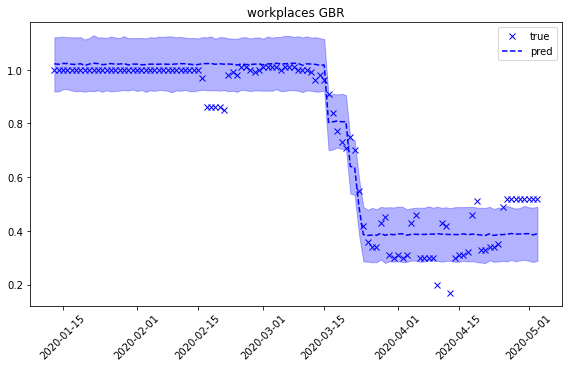

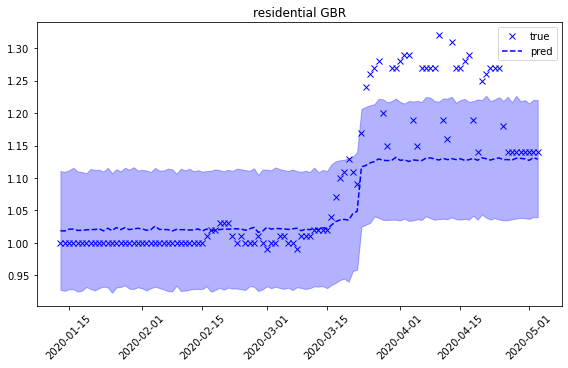

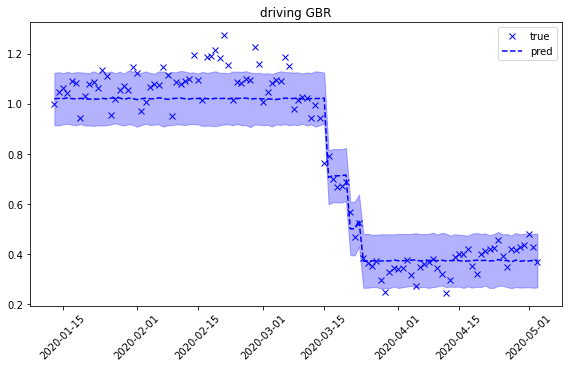

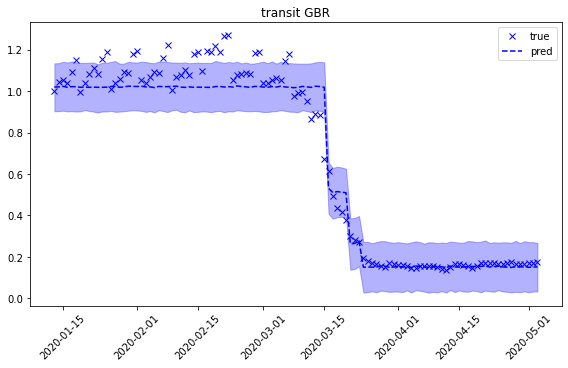

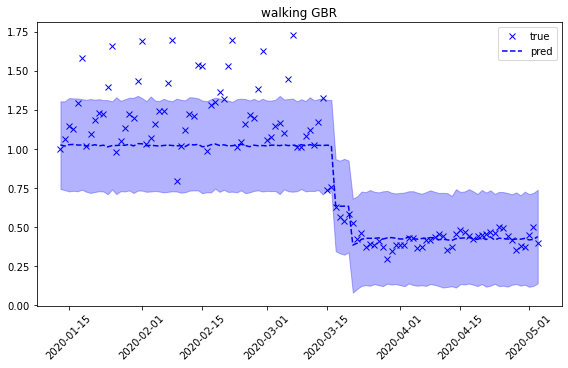

In [377]:
for country in country_codes:
    print(country)
    
    subset_measures, subset_mobility = build_dataset(country, mobility, oxford_long)
#     mcmc = run_mcmc(country, subset_measures, subset_mobility)
    y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), NB_MEASURES, NB_MOBILITIES, measures=subset_measures.to_numpy())['y']
    data = subset_mobility.to_numpy()
    times = subset_mobility.index
    plot_y_pred(y_pred, data, times, country)

# Misc

In [194]:
import matplotlib.pyplot as plt

def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = np.argsort(x)
    measures = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    mobility = subset_mobility.to_numpy()[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(measures, mean)
    ax.plot(measures, mobility, 'o')
    ax.fill_between(measures, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

samples_1 = mcmc.get_samples()

# Compute empirical posterior distribution over mu
posterior_mu = np.expand_dims(samples_1['a'], -1) + \
               np.exp(- np.expand_dims(samples_1['alpha'], -1) * subset_measures.to_numpy())

mean_mu = np.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(subset_measures.to_numpy(), mean_mu, hpdi_mu)
ax.set(xlabel='Measures', ylabel='Mobility', title='Regression line with 90% CI');

ValueError: Incompatible shapes for broadcasting: ((2000, 8, 3, 1), (1, 1, 112, 8))